# Preliminaries

In [1]:
# import modules
from typing import Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# base classes

class Node:
    pass


class Tree:
    def __init__(self):
        self.root = Node()

    def find_leaf(self, x) -> Node:
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

In [3]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()

    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D))  # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = calc_bbox(data)
        self.box = m, M

        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0]  # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                indices = np.random.choice(np.arange(0, len(valid_features)), D_try)
                left, right = make_density_split_node(node, N, valid_features[indices])
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise

        if np.sum(x < self.box[0]) > 0 or np.sum(x > self.box[1]) > 0:
            return 0.0
        return self.prior * leaf.response

In [4]:
def calc_loo_error(N_m: int, N: int, V_m: float) -> float:
    # print()
    # print(f'N_m = {N_m}')
    # print(f'N = {N}')
    # print(f'V_m = {V_m}')
    # print(f'-(2 * N_m * (N_m - 1)) = {-(2 * N_m * (N_m - 1))}')
    # print(f'(N * (N - 1) * V_m) = {(N * (N - 1) * V_m)}')
    # print(f'(N_m ** 2) = {(N_m ** 2)}')
    # print(f'((N ** 2) * V_m) = {((N ** 2) * V_m)}')
    # print(f'-(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m) = {-(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m)}')
    # print(f'(N_m ** 2) / ((N ** 2) * V_m) = {(N_m ** 2) / ((N ** 2) * V_m)}')
    # print()
    return -(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m) + (N_m ** 2) / ((N ** 2) * V_m)


def calc_volume(bounding_box: Tuple[np.ndarray, np.ndarray]):
    m, M = bounding_box
    return np.prod(M - m)


def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = 0, 0

    volume = calc_volume((m, M))

    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using
        # 'np.unique()'. Describe here why this is necessary.

        # It's necessary because otherwise if two instances have the same feature value the mean between them is the feature value self so the threshold would not be in the mid between feature values anymore

        # np.unique returns an already sorted array
        data_unique = np.unique(node.data[:, j])
        # Compute candidate thresholds
        tj = 0.5 * (data_unique[1:] + data_unique[:-1])

        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            # Compute the error
            N_l = np.sum(node.data[:, j] <= t)
            N_r = n - N_l

            l_volume = volume * t / (M[j] - m[j])
            r_volume = volume - l_volume

            if l_volume != 0 and r_volume != 0:
                loo_err_l = calc_loo_error(N_l, N, l_volume)
                loo_err_r = calc_loo_error(N_r, N, r_volume)

                loo_error = loo_err_l + loo_err_r

                # print(f'loo_error: {loo_error}')

                # choose the best threshold that
                if loo_error < e_min:
                    # print(f'e_min: {e_min}, j_min: {j_min}, t_min: {t_min}')
                    e_min = loo_error
                    j_min = j
                    t_min = t

    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:, j_min] <= t_min, :]  # store data in left node -- for subsequent splits
    left.box = m.copy(), M.copy()  # store bounding box in left node
    left.box[1][j_min] = t_min
    right.data = node.data[node.data[:, j_min] > t_min, :]
    right.box = m.copy(), M.copy()
    right.box[0][j_min] = t_min

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [5]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    v = calc_volume(node.box)
    node.response = n / (N * v)

# Decision Tree

In [6]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()

    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D))  # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels

        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0]  # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                indices = np.random.choice(np.arange(0, D), D_try)
                left, right = make_decision_split_node(node, indices)
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return np.argmax(leaf.response)

In [7]:
def calc_gini(N_l_k: np.ndarray, N_l: int) -> float:
    return N_l * (1 - (1 / N_l) * np.sum(N_l_k ** 2))


def calc_N_l_k(node_target: np.ndarray, tresholded_indices: np.ndarray) -> np.ndarray:
    return np.array([np.sum(node_target[tresholded_indices] == cls) for cls in range(10)])


def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    e_min = float('inf')
    t_min, j_min = 0, 0

    # find best feature j (among 'feature_indices') and best threshold t for the split
    for j in feature_indices:
        data_unique = np.unique(node.data[:, j])
        tj = 0.5 * (data_unique[1:] + data_unique[:-1])

        for t in tj:
            indices_l = np.where(node.data[:, j] <= t)
            indices_r = np.where(node.data[:, j] > t)

            N_l_k_l = calc_N_l_k(node.labels, indices_l)
            N_l_k_r = calc_N_l_k(node.labels, indices_r)

            N_l_l = len(indices_l)
            N_l_r = len(indices_r)

            gini_l = calc_gini(N_l_k_l, N_l_l)
            gini_r = calc_gini(N_l_k_r, N_l_r)

            gini = gini_l + gini_r

            if gini < e_min:
                e_min = gini
                t_min = t
                j_min = j

    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    indices_l = np.where(node.data[:, j_min] <= t_min)
    indices_r = np.where(node.data[:, j_min] > t_min)

    left.data = node.data[indices_l]  # data in left node
    left.labels = node.labels[indices_l]  # corresponding labels
    right.data = node.data[indices_r]
    right.labels = node.labels[indices_r]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [8]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.labels)
    node.response = np.bincount(node.labels, minlength=10) / node.N

In [9]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return len(np.unique(node.labels)) == 1

# Evaluation of Density and Decision Tree

In [10]:
# read and prepare the digits data
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits


def calc_bbox(data) -> (np.ndarray, np.ndarray):
    return np.min(data, axis=0).copy(), np.max(data, axis=0).copy()


digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# Removing features where min value == max value == 0, because this feature does not contain any information (it's the same for all instances)
smallest, biggest = calc_bbox(data)
distances = biggest - smallest
print(distances.shape)

dims_with_information = np.where(distances > 0)[0]
print(dims_with_information)

data = data[:, dims_with_information]
print(data.shape)

# Normalizing to values between 0 and 2
# data = data / 16
# print(calc_bbox(data))

(64,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63]
(1797, 61)


Density tree:
n_min: 40
0.20311630495269895
actual/expected    0         1         2         3         4         5    6  \
0                1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1                0.0  0.714286  0.101695  0.027322  0.000000  0.010989  0.0   
2                0.0  0.000000  0.451977  0.021858  0.000000  0.000000  0.0   
3                0.0  0.000000  0.022599  0.704918  0.000000  0.021978  0.0   
4                0.0  0.082418  0.000000  0.000000  0.861878  0.000000  0.0   
5                0.0  0.000000  0.022599  0.038251  0.011050  0.862637  0.0   
6                0.0  0.000000  0.000000  0.000000  0.000000  0.000000  1.0   
7                0.0  0.005495  0.000000  0.032787  0.116022  0.032967  0.0   
8                0.0  0.197802  0.401130  0.174863  0.005525  0.043956  0.0   
9                0.0  0.000000  0.000000  0.000000  0.005525  0.027473  0.0   

actual/expected         7         8         9  
0                0.000000  0.000000  0

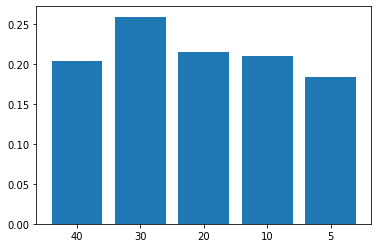


Decision tree:
n_min: 40
0.27378964941569284
actual/expected         0         1         2         3         4         5  \
0                0.910112  0.000000  0.005650  0.005464  0.049724  0.010989   
1                0.000000  0.862637  0.073446  0.010929  0.077348  0.032967   
2                0.000000  0.038462  0.683616  0.098361  0.000000  0.071429   
3                0.022472  0.021978  0.101695  0.650273  0.000000  0.148352   
4                0.016854  0.010989  0.005650  0.010929  0.812155  0.021978   
5                0.005618  0.010989  0.016949  0.065574  0.016575  0.598901   
6                0.033708  0.010989  0.084746  0.071038  0.011050  0.027473   
7                0.005618  0.000000  0.000000  0.010929  0.027624  0.010989   
8                0.000000  0.032967  0.022599  0.038251  0.000000  0.027473   
9                0.005618  0.010989  0.005650  0.038251  0.005525  0.049451   

actual/expected         6         7         8         9  
0                0.016575 

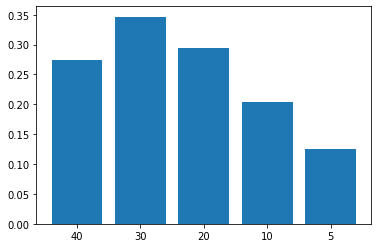

In [11]:
# train trees, plot training error confusion matrices, and comment on your results

def calc_confusion_matrix(calculated_target, expected) -> pd.DataFrame:
    matrix = np.zeros((10, 10))
    matrix_dict = {}
    for expected_num in range(10):
        expected_indices = np.where(expected == expected_num)[0]
        calculated_values = calculated_target[expected_indices]
        calc_bins = np.bincount(calculated_values, minlength=10)
        matrix[expected_num] = calc_bins / len(expected_indices)
        matrix_dict[expected_num] = calc_bins / len(expected_indices)

    data_frame = pd.DataFrame(matrix_dict)
    data_frame.columns.name = 'actual/expected'
    return data_frame


def show_plot(errors: np.ndarray, n_mins: np.ndarray):
    x = range(len(n_mins))
    x_ticks = np.arange(len(n_mins))
    fig, ax = plt.subplots()
    ax.bar(x, errors)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(n_mins)
    plt.show()


def train_test_density_tree(n_min) -> float:
    density_trees: List[DensityTree] = []
    for number in range(10):
        indices = np.where(target == number)
        filtered_data = data[indices]
        prior = len(filtered_data) / len(data)

        density_tree = DensityTree()
        density_tree.train(filtered_data, prior, n_min)
        density_trees.append(density_tree)

    calculated_target = np.zeros(len(target), dtype=int)

    for i, instance in enumerate(data):
        p_max = -1
        num_max = -1
        for number, tree in enumerate(density_trees):
            p = tree.predict(instance)
            if p > p_max:
                p_max = p
                num_max = number
        calculated_target[i] = num_max

    # print(target)
    # print(calculated_target)
    density_tree_err = calculated_target != target
    # print(density_tree_err)

    density_tree_err_rate = np.sum(density_tree_err) / len(target)
    confusion_matrix = calc_confusion_matrix(calculated_target, target)
    print(density_tree_err_rate)
    print(confusion_matrix)

    return density_tree_err_rate


def train_test_decision_tree(n_min) -> float:
    decision_tree = DecisionTree()
    decision_tree.train(data, target, n_min)

    calculated_target = np.array([decision_tree.predict(instance) for instance in data], dtype=int)

    decision_tree_err = calculated_target != target
    # print(decision_tree_err)

    decision_tree_err_rate = np.sum(decision_tree_err) / len(target)
    confusion_matrix = calc_confusion_matrix(calculated_target, target)
    print(decision_tree_err_rate)
    print(confusion_matrix)

    return decision_tree_err_rate


n_mins = [40, 30, 20, 10, 5]
density_tree_error = []
print('Density tree:')
for hyper_n_min in n_mins:
    print(f'n_min: {hyper_n_min}')
    error = train_test_density_tree(hyper_n_min)
    density_tree_error.append(error)
show_plot(density_tree_error, n_mins)

decision_tree_error = []
print()
print('Decision tree:')
for hyper_n_min in n_mins:
    print(f'n_min: {hyper_n_min}')
    error = train_test_decision_tree(hyper_n_min)
    decision_tree_error.append(error)
show_plot(decision_tree_error, n_mins)


The adjustment of the hyperparameter has the same form for both the density tree and the decision tree. Thus the deviation in the errors is for the decision tree broader.
Both perform best with smaller n_min and the decision tree with n_min = 5 performs best

# Density and Decision Forest

In [12]:
class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]

    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            ...  # your code here

    def predict(self, x):
        # compute the ensemble prediction
        return ...  # your code here

In [13]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]

    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            ...  # your code here

    def predict(self, x):
        # compute the ensemble prediction
        return ...  # your code here

# Evaluation of Density and Decision Forest

In [14]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
...  # your code here
